In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.impute import KNNImputer

from sklearn.utils import shuffle

import xgboost as xgb

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
 
# plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['figure.dpi'] = 300

SEED = 42
np.random.seed(SEED)

In [2]:
from models import DataManager, ModelBuilder, SHAPExplainer

# 1. Data
## 1.1 Load Data

In [3]:
dMana = DataManager(r"D:\pre_grad_research\MantleWater\HDiff-XAI\all_data_20220606.xlsx", sheet_name='train')
dMana.choose_X_y([10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Area          1904 non-null   object 
 1   Location      1904 non-null   object 
 2   Rock type     1904 non-null   object 
 3   Rock Label    1846 non-null   object 
 4   Sample type   1904 non-null   object 
 5   Point Label   1904 non-null   object 
 6   Geo_Set       1904 non-null   object 
 7   latitude      1904 non-null   float64
 8   longitude     1904 non-null   float64
 9   No.           1904 non-null   int64  
 10  Si            1904 non-null   float64
 11  Ti            1904 non-null   float64
 12  Al            1904 non-null   float64
 13  Cr            1904 non-null   float64
 14  Fe            1904 non-null   float64
 15  Ca            1904 non-null   float64
 16  Mg            1904 non-null   float64
 17  Mn            1904 non-null   float64
 18  Na            1868 non-null 

## 1.2 Missing value Imputation

### 1.2.1 kNN Imputation

In [4]:
dMana.impute(neighbor_cnt=30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Si        1904 non-null   float64
 1   Ti        1904 non-null   float64
 2   Al        1904 non-null   float64
 3   Cr        1904 non-null   float64
 4   Fe        1904 non-null   float64
 5   Ca        1904 non-null   float64
 6   Mg        1904 non-null   float64
 7   Mn        1904 non-null   float64
 8   Na        1904 non-null   float64
 9   H$_{2}$O  1904 non-null   float64
dtypes: float64(10)
memory usage: 148.9 KB
None


## 1.3 Train-test split

In [5]:
dMana.split_train_test(ratio=0.2)

Training X: (1523, 10) Testing X: (381, 10)
Training Y: (1523,) Testing y: (381,)


# 2. Model

## 2.1 Fixed Hyperparameters

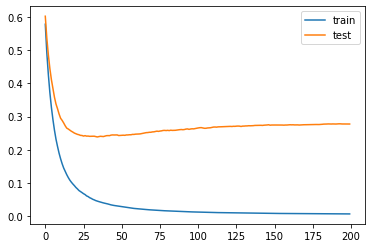

In [6]:
model_xgb_tmp = ModelBuilder(fix_param=dict([('learning_rate', 0.15), ('n_estimators', 200)]))
model_xgb_tmp.initialize()
eval_set = [(dMana.X_train, dMana.y_train), (dMana.X_test, dMana.y_test)]
model_xgb_tmp.model.fit(dMana.X_train, dMana.y_train, eval_metric='logloss', eval_set=eval_set, verbose=False)
results = model_xgb_tmp.model.evals_result()
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
plt.legend()
plt.show()

## 2.2 Hyperparameter Tuning

+ Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
+ Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
+ Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
+ Lower the learning rate and decide the optimal parameters.

In [7]:
def GS(param_default, search_grid, X_train, Y_train, scoring):
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, )
    grid_search = GridSearchCV( xgb.XGBClassifier(**param_default, 
                                                  eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=SEED,),
                                search_grid, cv=kfold, scoring=scoring, refit=True, verbose=4, n_jobs=-1, )
    
    model_best = grid_search.fit(X_train, Y_train)
    
    print(model_best.best_score_)
    print(model_best.best_estimator_)
    print(model_best.best_estimator_.get_params())
    return model_best

In [8]:
import copy

def get_models(param_list, pname, prange):
    models = dict()
    for i in prange:  # np.arange()
        key = '%.1f' % i
        param_list_tmp = copy.deepcopy(param_list)  # safe option
        param_list_tmp[pname] = i
        models[key] = xgb.XGBClassifier(**param_list_tmp, 
                                        eval_metric='logloss', scale_pos_weight=scale_pos_weight, random_state=SEED, )
    return models

def evaluate_model(model, X, y, scoring):
    # define the evaluation procedure
    # kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, )
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X, y, scoring=scoring, cv=kfold, n_jobs=-1, )
    return scores

In [9]:
def single_param(param_list, pname, prange, X, y, scoring):
    # get the models to evaluate
    models = get_models(param_list, pname, prange)
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        # evaluate the model
        scores = evaluate_model(model, X, y, scoring)
        # store the results
        names.append(name)
        results.append(scores)
        # summarize the performance along the way
        print('>%s %.4f (%.4f)' % (name, np.mean(scores), np.std(scores)))
    
    plt.boxplot(results, labels=names, showmeans=True)
    plt.xlabel(pname)
    plt.ylabel(scoring)
    plt.show()

### 2.2.1 Relatively high eta: 
#### {eta} => ?rounds

In [15]:
scoring = 'roc_auc'  # roc_auc, f1
scale_pos_weight = 1

>50.0 0.9813 (0.0033)
>150.0 0.9833 (0.0033)
>250.0 0.9834 (0.0035)
>350.0 0.9832 (0.0038)
>450.0 0.9830 (0.0039)
>550.0 0.9828 (0.0038)
>650.0 0.9828 (0.0039)
>750.0 0.9827 (0.0040)
>850.0 0.9826 (0.0040)
>950.0 0.9825 (0.0039)
>1050.0 0.9824 (0.0039)


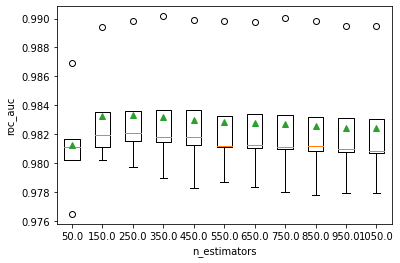

In [16]:
param_1 = dict([('learning_rate', 0.15), ])
single_param(param_1, 'n_estimators', np.arange(50, 1100, 100), dMana.X_train, dMana.y_train, scoring)  

### 2.2.2 Tree-specific:  depth, hessians, gamma, subsample, colsample
#### {eta, rounds} => ?max_depth, min_child_weight

In [21]:
%%time
param_2 = dict([('learning_rate', 0.15), ('n_estimators', 250)])
search_grid_1 = dict([('max_depth', np.arange(4, 9, 1)), ('min_child_weight', np.arange(0.5, 2, 0.1))])
GS(param_2, search_grid_1, dMana.X_train, dMana.y_train, scoring)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.9846260909986972
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.15, max_delta_step=0,
              max_depth=6, min_child_weight=1.0999999999999999, missing=nan,
              monotone_constraints='()', n_estimators=250, n_jobs=16,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'enable_categorical': False, 'gamma': 0, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate': 0.15, 'max

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=Non...
                                     n_estimators=250, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                 

#### [ALT] {eta, rounds} => ?max_depth

In [ ]:
param_2 = dict([('learning_rate', 0.15), ('n_estimators', 250)])
# search_grid_1 = dict([('max_depth', np.arange(5, 9, 1)), ('min_child_weight', np.arange(0.5, 10, 2))])
# GS(param_2, search_grid_1, X_train, Y_train, 'f1')
single_param(param_2, 'max_depth', np.arange(3, 9, 1), dMana.X_train, dMana.y_train, scoring)

#### [ALT] {eta, rounds, max_depth} => ?min_child_weight

In [ ]:
param_3 = dict([('learning_rate', 0.15), ('n_estimators', 250), ('max_depth', 4)])
single_param(param_3, 'min_child_weight', np.arange(0.1, 3, 0.3) , X_train, Y_train, scoring)  # np.arange(0.2, 2, 0.2)

#### {eta, rounds, max_depth, min_child_weight} => ?gamma

>0.1 0.9839 (0.0023)
>0.2 0.9840 (0.0028)
>0.3 0.9837 (0.0028)
>0.4 0.9831 (0.0025)
>0.5 0.9828 (0.0026)
>0.6 0.9823 (0.0021)
>0.7 0.9826 (0.0030)
>0.8 0.9828 (0.0028)
>0.9 0.9820 (0.0029)


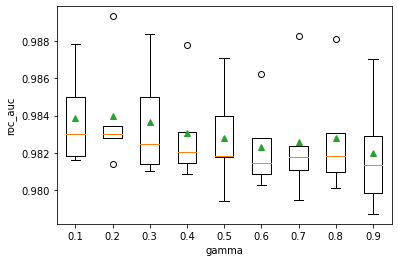

Wall time: 11.8 s


In [23]:
%%time
param_3 = dict([('learning_rate', 0.15), ('n_estimators', 250), ('max_depth', 6), ('min_child_weight', 1.1)])
single_param(param_3, 'gamma', np.arange(0.1, 1, 0.1), dMana.X_train, dMana.y_train, scoring)  # np.arange(0.1, 1, 0.2), [0, 0.5, 1, 10, 100]

#### {eta, rounds, max_depth, min_child_weight, gamma}, => ?subsample, ?colsample_bytree

In [24]:
%%time
param_4 = dict([('learning_rate', 0.15), ('n_estimators', 250), ('max_depth', 6), ('min_child_weight', 1.1), ('gamma', 0.2)])
search_grid_2 = dict([('subsample', np.arange(0.5, 1.01, 0.1)), ('colsample_bytree', np.arange(0.5, 1.01, 0.1))])
GS(param_4, search_grid_2, dMana.X_train, dMana.y_train, scoring)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.9849454548663678
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9999999999999999,
              enable_categorical=False, eval_metric='logloss', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1.1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8999999999999999,
              tree_method='exact', validate_parameters=1, verbosity=None)
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 0.9999999999999999, 'enable_categorical': False, 'gamma': 0.2, 'gpu_id': -1, 'importance_type': None, 'int

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0.2,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None...
                                     n_estimators=250, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=1,
                                 

### 2.2.3 Regularization Parameters 
#### {eta, rounds, max_depth, min_child_weight, gamma, subsample, colsample_bytree} => ?reg_lambda, ?reg_alpha

In [27]:
%%time
param_5 = dict([('learning_rate', 0.15), ('n_estimators', 250), ('max_depth', 6), ('min_child_weight', 1.1), ('gamma', 0.2), ('subsample', 0.9), ('colsample_bytree', 1.0)])
search_grid_3 = dict([('reg_lambda', [0, 1e-3, 1e-2, 0.1, 1, ]), ('reg_alpha', [0, 1e-3, 1e-2, 0.1, 1, ])])
GS(param_5, search_grid_3, dMana.X_train, dMana.y_train, scoring)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


0.9850076170314959
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              enable_categorical=False, eval_metric='logloss', gamma=0.2,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.15, max_delta_step=0, max_depth=6,
              min_child_weight=1.1, missing=nan, monotone_constraints='()',
              n_estimators=250, n_jobs=16, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)
{'objective': 'binary:logistic', 'use_label_encoder': True, 'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1.0, 'enable_categorical': False, 'gamma': 0.2, 'gpu_id': -1, 'importance_type': None, 'interaction_constraints': '', 'learning_rate

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=1.0,
                                     enable_categorical=False,
                                     eval_metric='logloss', gamma=0.2,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.15, max_delta_step=None,...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=250, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=42, reg_alpha=None,
                              